## Import depencences and the dataset

In [10]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gradio as gr
from PIL import Image



# Visualize some predictions
def plot_predictions(X, y_true, y_pred, indices):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, idx in enumerate(indices):
        ax = axes[i//5, i % 5]
        ax.imshow(X[idx].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f'True: {y_true[idx]}\nPred: {y_pred[idx]}')
    plt.tight_layout()
    plt.show()


def get_dataset():   
    # Load MNIST dataset
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    # Convert data to float32 for better performance
    X = X.astype('float32')

    # Keep only digits 0 and 1
    mask = (y == '0') | (y == '1')
    X = X[mask]
    y = y[mask]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    print("Training set size:", X_train.shape[0])
    print("Test set size:", X_test.shape[0])

    print("Display a few examples of the images")
    # Display a few examples of digits 0 and 1
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {y[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    return X_train, X_test, y_train, y_test

# plot one sample digit such that the value of each pixel is shown along with a color
def plot_single_image_with_values(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image.reshape(28, 28), cmap='gray')
    for (i, j), value in np.ndenumerate(image.reshape(28, 28)):
        plt.text(j, i, f'{value:.0f}', ha='center',
                 va='center', color='red', fontsize=8)
    plt.axis('off')
    plt.show()

## Get Data

Training set size: 11824
Test set size: 2956
Display a few examples of the images


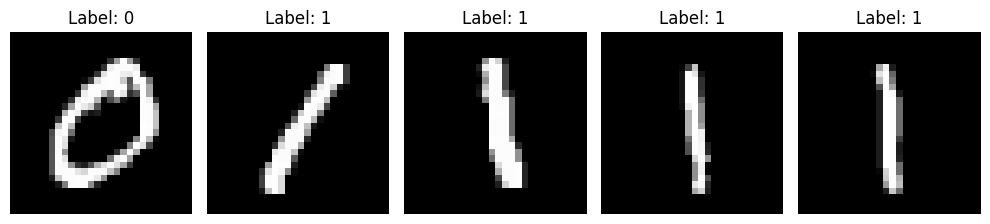

In [11]:
X_train, X_test, y_train, y_test = get_dataset()

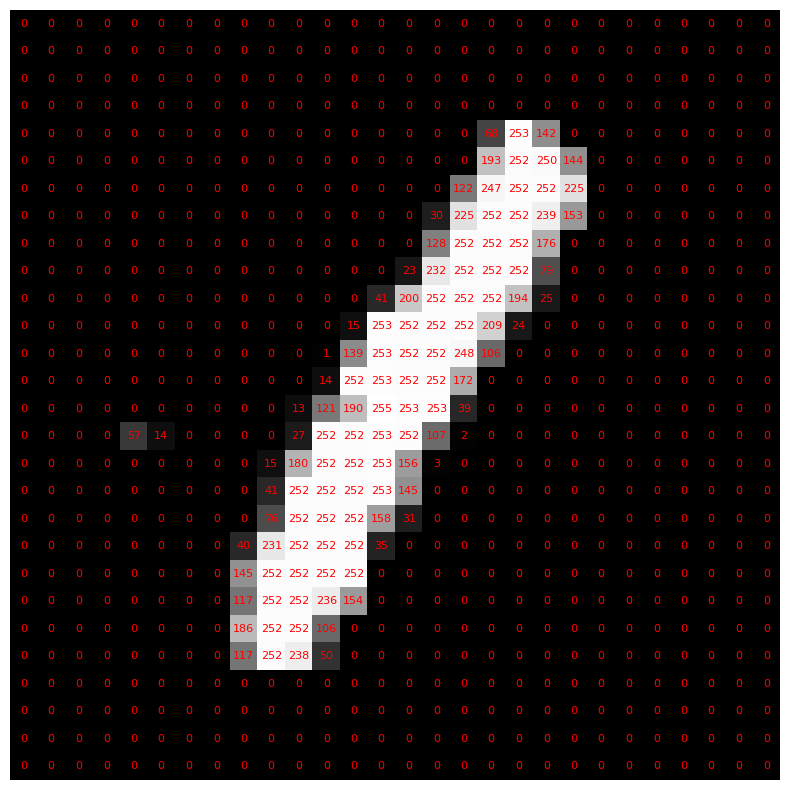

In [12]:
# Plot a single image from X_train
plot_single_image_with_values(X_train[0])

In [13]:
# Scale the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Create and train the neural network
# Assignment: Play with this model definition. Add or remove layers and neurons.
model = MLPClassifier(hidden_layer_sizes=(100,),
                      max_iter=5,
                      random_state=42,
                      verbose=True)


model.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.05533521
Iteration 2, loss = 0.00469684
Iteration 3, loss = 0.00243111
Iteration 4, loss = 0.00178924
Iteration 5, loss = 0.00137547


/Users/amirhosseinmohajerani/Desktop/code/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=5, random_state=42, verbose=True)

In [15]:
# print the number of model parameters
n_params = sum(np.prod(w.shape) for w in model.coefs_) + \
    sum(np.prod(b.shape) for b in model.intercepts_)
print(f"Number of trainable parameters: {n_params}")

Number of trainable parameters: 78601


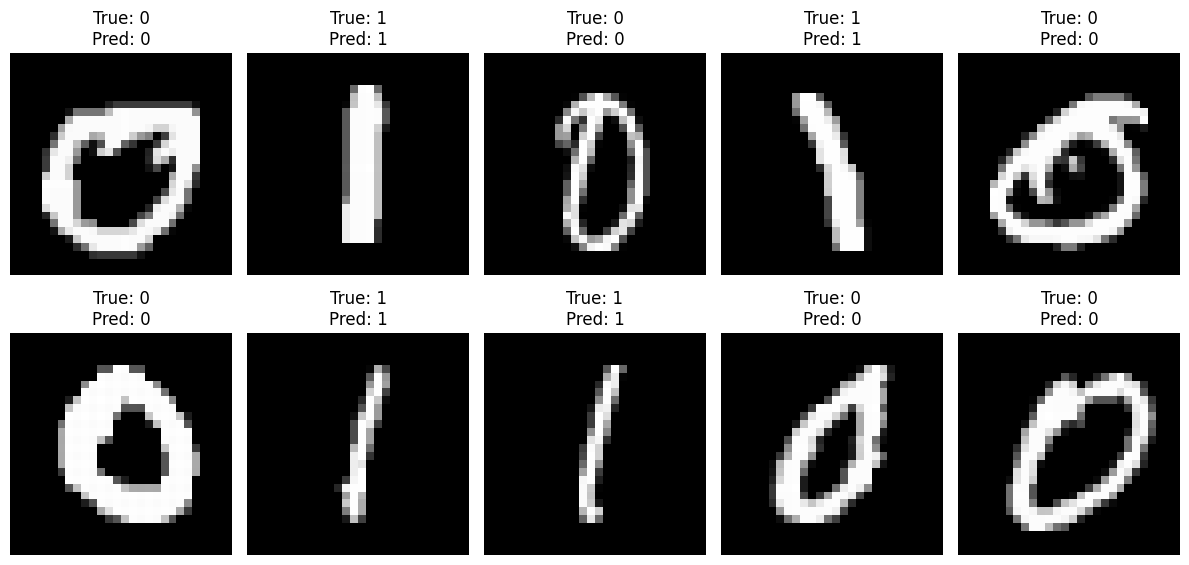

In [16]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Show some random test examples
indices = [0,1,2,3,4,5,6,7,8,9]
plot_predictions(X_test, y_test, y_pred, indices)

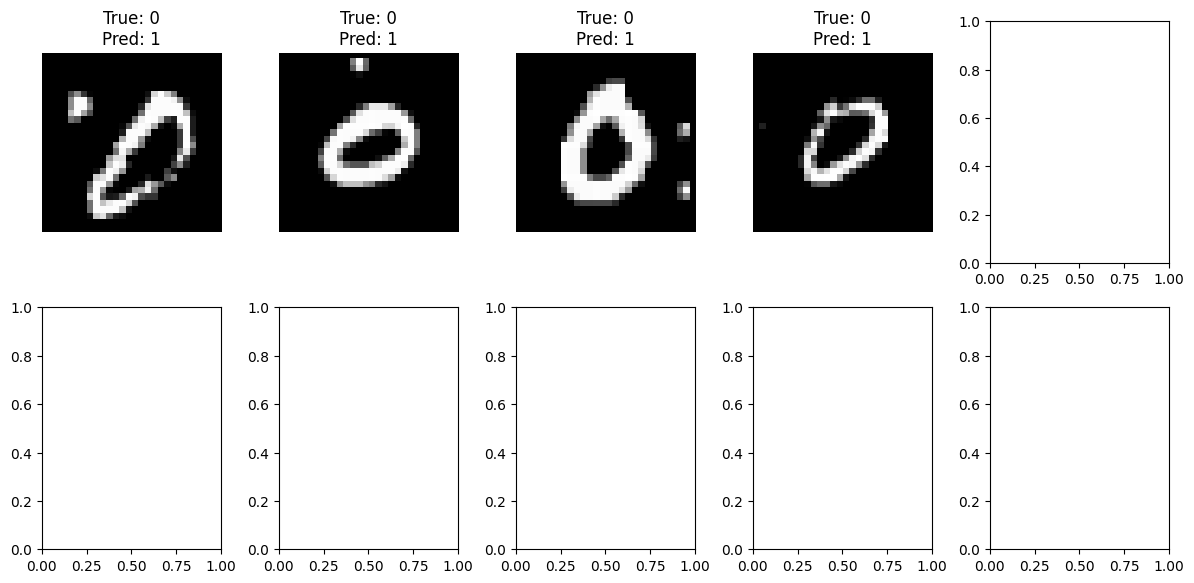

Model accuracy: 99.86%


In [17]:
# find 10 examples where the model made wrong predictions 
misclassified_indices = np.where(y_pred != y_test)[0]
# Select first 10 misclassified examples
wrong_indices = misclassified_indices[:5]

# Display the misclassified examples
plot_predictions(X_test, y_test, y_pred, wrong_indices)

# Print accuracy score
accuracy = (y_pred == y_test).mean()
print(f"Model accuracy: {accuracy:.2%}")

In [18]:
# Define the prediction function

def predict_digit(image):
    if image is None:
        return ""
    # Extract the actual image data from the Gradio input
    if isinstance(image, dict):
        image = image['composite']
    image = image[:, :, 3]  # No need for shape check since we know it's (600, 800, 4)

    # Convert to grayscale and resize
    image = Image.fromarray(image).resize((28, 28))
    img = np.array(image)

    img = img.reshape(1,784).astype('float32')

    # Scale the input using the same scaler used for training
    img_scaled = scaler.transform(img)
    

    # Make prediction
    prediction = model.predict(img_scaled)[0]
    confidence = model.predict_proba(img_scaled)[0]
    del img
    del img_scaled
    del image

    # Map the prediction to the correct digit
    # Assuming the model is trained on two classes, we can use the unique classes from y_train
    unique_classes = np.unique(y_train)
    predicted_digit = unique_classes[int(prediction)]

    return f"Prediction: {predicted_digit}\nConfidence: {confidence[int(prediction)]:.5%}"

# Create Gradio interface
iface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Sketchpad(height=280,width=280),
    outputs="text",
    live=False,
    title="Handwritten Digit Recognition",
    description="Draw a digit and the model will predict it in real-time!",
    examples=[],
    allow_flagging="never"
)

# Launch the interface
iface.launch()

/Users/amirhosseinmohajerani/Desktop/code/.venv/lib/python3.13/site-packages/gradio/interface.py:403: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
